In [2]:
import numpy as np
import os, urllib
from astropy.io import fits
from astropy.table import Table, Column
from pandas import read_csv
from datetime import datetime
import pytz
import util
import socket
import pdb
import matplotlib.pyplot as plt
from matplotlib import dates as mp_dates
%matplotlib inline

In [9]:
##There aren't frames open and closed at the same points in time, so I'll match them as close as possible
##For a given point in one file, it looks for the closest time in the other file and matches their data
##it also creates a new time thats the average of the times of the two correlated points


base_file = "/Users/fatimaabdurrahman/Desktop/Research/RUN4/20170215/FLI/reduce/stats/stats_open_mdp.fits"
comp_file = "/Users/fatimaabdurrahman/Desktop/Research/RUN4/20170215/FLI/reduce/stats/stats_closed_mdp.fits"

#function body

stats1 = Table.read(base_file)
stats2 = Table.read(comp_file)

UTC_TIME = np.zeros(len(stats1), dtype='S15')
UTC_DATE = np.zeros(len(stats2), dtype='S15')
data_open = np.zeros(len(stats1),dtype=float)
data_closed = np.zeros(len(stats1), dtype=float)

for ii in range(len(stats1)):
    data_open[ii] = stats1['emp_fwhm'][ii]
    
    dt_str = stats1['DATE_UTC'][ii] + ' ' + stats1['TIME_UTC'][ii]
    dt_utc = datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S')

    times2 = []
    for jj in range(len(stats2)):
        dt_str2 = stats2['DATE_UTC'][jj] + ' ' + stats2['TIME_UTC'][jj]
        dt_utc2 = datetime.strptime(dt_str2, '%Y-%m-%d %H:%M:%S')
        diff = abs(dt_utc-dt_utc2)
        times2.append(diff)
    
    min_id = np.argmin(times2)
    data_closed[ii] = stats2['emp_fwhm'][min_id]
    
    time2_str = stats2['DATE_UTC'][min_id] + ' ' + stats2['TIME_UTC'][min_id]
    time2_utc = datetime.strptime(time2_str, '%Y-%m-%d %H:%M:%S')
    diff_time = time2_utc - dt_utc
    ave_time = dt_utc + (diff_time/2)

    
    date_time = ((ave_time.isoformat().split('T')))
    UTC_TIME[ii] = str(date_time[1])[:8] #cuts of .5 second if present
    UTC_DATE[ii] = str(date_time[0])


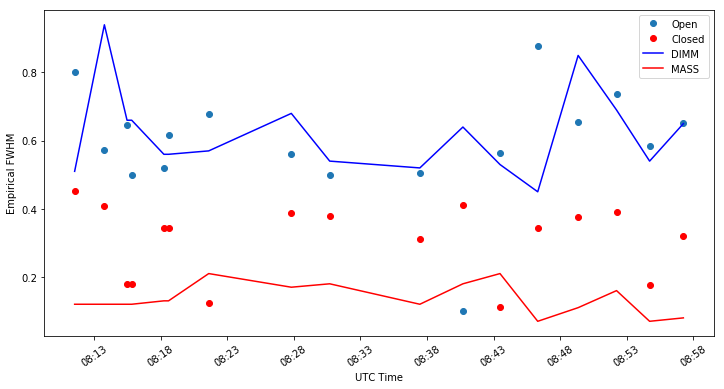

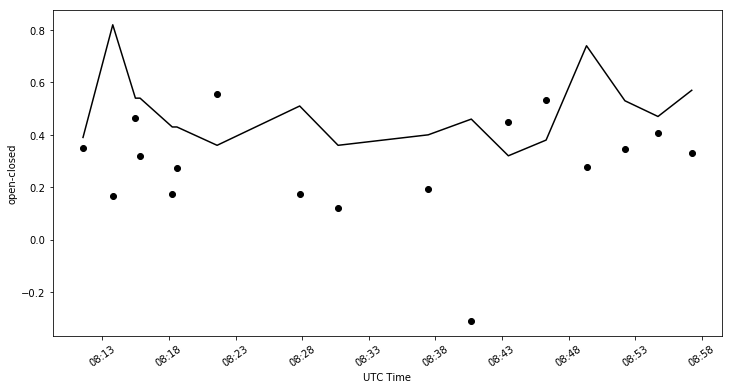

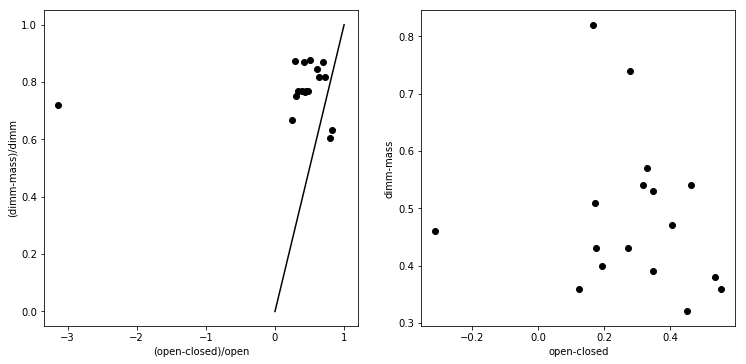

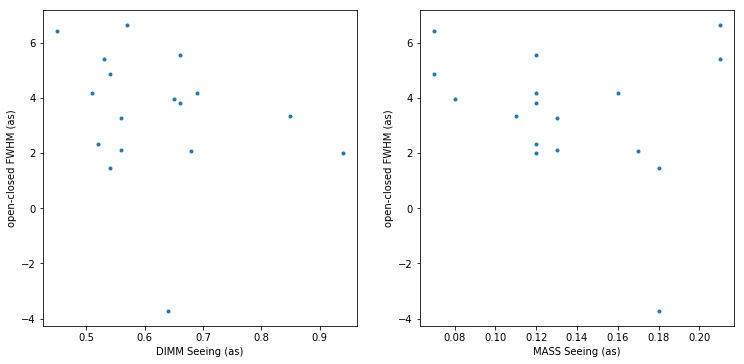

In [22]:
mass = stats1['MASS']
dimm = stats1['DIMM']

scale = 12

times = []
for i in range(len(UTC_TIME)):
    string = str(UTC_DATE[i])+str(UTC_TIME[i])
    dt_obj = datetime.strptime(string, "b'%Y-%m-%d'b'%H:%M:%S'")
    times.append(dt_obj)
    
plt.figure(1, figsize=(12, 6))
plt.plot(times, data_open/scale, 'o', label="Open")
plt.plot(times, data_closed/scale, 'ro', label="Closed")
plt.plot(times, dimm, 'b-')
plt.plot(times, mass, 'r-')
plt.ylabel("Empirical FWHM")
plt.xlabel("UTC Time")
plt.xticks(rotation=35)
plt.gca().xaxis.set_major_formatter(mp_dates.DateFormatter('%H:%M'))
plt.legend()

diff = data_open-data_closed
plt.figure(2, figsize=(12, 6))
plt.plot(times, diff/scale, 'ko')
plt.plot(times, dimm-mass, 'k-')
plt.xlabel("UTC Time")
plt.ylabel("open-closed")
plt.xticks(rotation=35)
plt.gca().xaxis.set_major_formatter(mp_dates.DateFormatter('%H:%M'))

y = (dimm - mass)/dimm
x = (data_open - data_closed)/data_open
plt.figure(3, figsize=(12, 6))
plt.subplots_adjust(left=0.1, bottom=0.15)
plt.subplot(121)
plt.plot(x, y, 'ko')
plt.plot([0, 1], [0, 1], 'k-')
plt.xlabel("(open-closed)/open")
plt.ylabel("(dimm-mass)/dimm")

plt.subplot(122)
plt.plot(((data_open/scale)-(data_closed/scale)), (dimm-mass), 'ko')
plt.xlabel("open-closed")
plt.ylabel("dimm-mass")

plt.figure(4, figsize=(12,6))

###Differences vs seeing###

#difference v dimm#
plt.subplots_adjust(left=0.1, bottom=0.15)
plt.subplot(121)
plt.plot(dimm, diff, '.')
plt.xlabel("DIMM Seeing (as)")
plt.ylabel("open-closed FWHM (as)")

#difference v mass#
plt.subplot(122)
plt.plot(mass, diff, '.')
plt.xlabel("MASS Seeing (as)")
plt.ylabel("open-closed FWHM (as)")

# Calibrating observations to MASS/DIMM wavelength

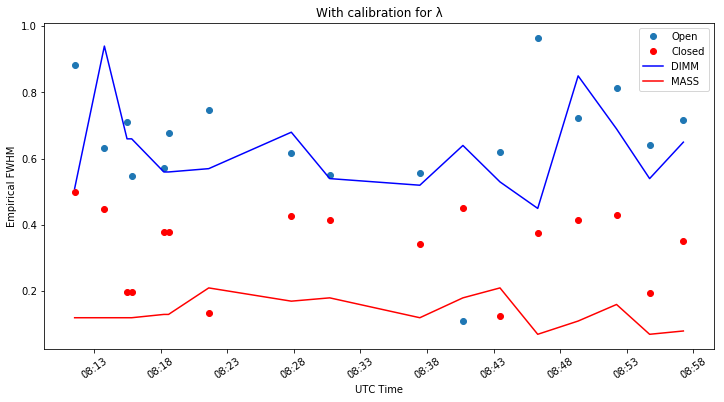

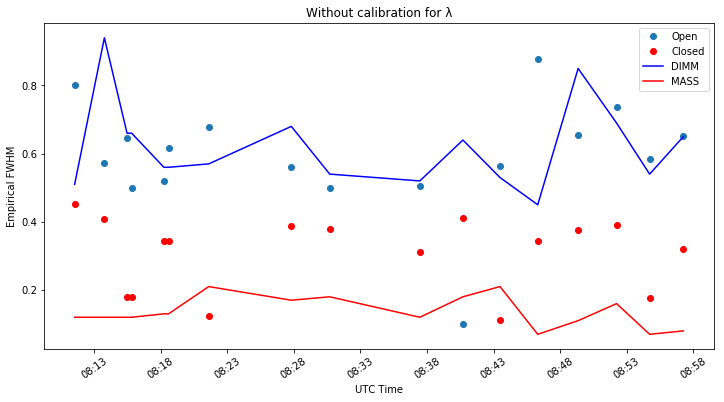

In [16]:
mass = stats1['MASS']
dimm = stats1['DIMM']

scale = 12

obs_wav = 806 #nm
cal_wav = 500 #mass/dimm data wavelength (nm)
cal_fac = (obs_wav/cal_wav)**(1/5) #calibration factor


times = []
for i in range(len(UTC_TIME)):
    string = str(UTC_DATE[i])+str(UTC_TIME[i])
    dt_obj = datetime.strptime(string, "b'%Y-%m-%d'b'%H:%M:%S'")
    times.append(dt_obj)
    
plt.figure(1, figsize=(12, 6))
plt.plot(times, (data_open/scale)*cal_fac, 'o', label="Open")
plt.plot(times, (data_closed/scale)*cal_fac, 'ro', label="Closed")
plt.plot(times, dimm, 'b-')
plt.plot(times, mass, 'r-')
plt.ylabel("Empirical FWHM")
plt.xlabel("UTC Time")
plt.xticks(rotation=35)
plt.title("With calibration for λ")
plt.gca().xaxis.set_major_formatter(mp_dates.DateFormatter('%H:%M'))
plt.legend()

plt.figure(2, figsize=(12, 6))
plt.plot(times, (data_open/scale), 'o', label="Open")
plt.plot(times, (data_closed/scale), 'ro', label="Closed")
plt.plot(times, dimm, 'b-')
plt.plot(times, mass, 'r-')
plt.ylabel("Empirical FWHM")
plt.xlabel("UTC Time")
plt.title('Without calibration for λ')
plt.xticks(rotation=35)
plt.gca().xaxis.set_major_formatter(mp_dates.DateFormatter('%H:%M'))
plt.legend()


# diff = data_open-data_closed
# plt.figure(2, figsize=(12, 6))
# plt.plot(times, diff/scale, 'ko')
# plt.plot(times, dimm-mass, 'k-')
# plt.xlabel("UTC Time")
# plt.ylabel("open-closed")
# plt.xticks(rotation=35)
# plt.gca().xaxis.set_major_formatter(mp_dates.DateFormatter('%H:%M'))

# y = (dimm - mass)/dimm
# x = (data_open - data_closed)/data_open
# plt.figure(3, figsize=(12, 6))
# plt.subplots_adjust(left=0.1, bottom=0.15)
# plt.subplot(121)
# plt.plot(x, y, 'ko')
# plt.plot([0, 1], [0, 1], 'k-')
# plt.xlabel("(open-closed)/open")
# plt.ylabel("(dimm-mass)/dimm")

# plt.subplot(122)
# plt.plot(((data_open/scale)-(data_closed/scale)), (dimm-mass), 'ko')
# plt.xlabel("open-closed")
# plt.ylabel("dimm-mass")

# plt.figure(4, figsize=(12,6))

# ###Differences vs seeing###

# #difference v dimm#
# plt.subplots_adjust(left=0.1, bottom=0.15)
# plt.subplot(121)
# plt.plot(dimm, diff, '.')
# plt.xlabel("DIMM Seeing (as)")
# plt.ylabel("open-closed FWHM (as)")

# #difference v mass#
# plt.subplot(122)
# plt.plot(mass, diff, '.')
# plt.xlabel("MASS Seeing (as)")
# plt.ylabel("open-closed FWHM (as)")